<a href="https://colab.research.google.com/github/sumukhig/nlp-text-summarization/blob/main/NLP_Project_Group10_BART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Necessary Packages

In [2]:
! pip install -U sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 701.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=c22fc59894ea8d52dcc866f857474194ca11dc1a53b46e1716c6f8031473839c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
import random
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Extracting Research Paper Data From XML files

In [4]:
import xml.etree.ElementTree as ET

xml_file_path = "W99-0629.xml"
#xml_file_path = "/Users/sindhuswaroop/Documents/NEU/Semester 4/NLP/Project/scisummnet_release1.1__20190413/top1000_complete/W99-0623/Documents_xml/W99-0623.xml"
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Function to extract all text data from the XML tree
def extract_text_data(element):
    # Some data cleaning steps
    text = (element.text or "").strip()
    text_data = text.lower()
    text_data = text_data.replace("quot", "")
    text_data = re.sub(r'https?://\S+', '', text_data)
    text_data = re.sub(r'[^\w\s]', '', text_data)

    for child in element:
        text_data = np.append(text_data, extract_text_data(child))

    return text_data

# Extract all data as a list of sentences
all_data_text = list(extract_text_data(root))

In [5]:
# Remove any empty quotes from the list that have been generated as a result of whitespaces
corpus_init = [item for item in all_data_text if item != '']
# Remove the title of the paper from the corpus
corpus = corpus_init[1:]

### Perform Seq2Seq

In [14]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Initialize the model and tokenizer.\
# https://huggingface.co/facebook/bart-large-cnn
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Join the list of sentences into a single string.
article = " ".join(corpus)

# Tokenize the article.
inputs = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=1024, truncation=True)

# Generate the summarized text.
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the summarized text.
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(summary)


In this paper we discuss cascaded memory based grammatical relations assignment in the first stages of the cascade we find chunks of several types and label them with their adverbial function. In the last stage we assign grammatical relation to pairs of chunks and we studied the effect of adding several levels to this cascaded classifier. We found that even the less performing chunkers enhanced the performance of the relation finder when dealing with large amounts of text.


### Evaluate Text Summary

In [15]:
! pip install transformers datasets rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=073965eb925b299d151ea1c5c2842fec1e40d6b8d5f78ef51ed1691261e036cf
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [16]:
# Import necessary packages
from rouge_score import rouge_scorer

In [17]:
# reference_summaries = ["Three state-of-the-art statistical parsers are combined to produce more accurate parses, \
# as well as new bounds on achievable Treebank parsing accuracy. Two general approaches are presented and two combination \
# techniques are described for each approach. Both parametric and non-parametric models are explored. The resulting parsers \
# surpass the best previously published performance results for the Penn Treebank. We improve the best parser's F-measure of \
# 89.7 to 91.3, using naive Bayes voting on the Penn TreeBank constituent structures (16% error reduction). Regarding the \
# system combination study, we propose two parser combination schemes, one that selects an entire tree from one of the parsers, \
# and one that builds a new tree by selecting constituents suggested by the initial trees. We perform parse selection by \
# maximizing the expected precision of the selected parse with respectto the set of parses being combined."]

reference_summaries = ["In this paper we discuss cascaded Memory-Based grammatical relations assignment. In the first stages \
of the cascade, we find chunks of several types (NP,VP,ADJP,ADVP,PP) and label them with their adverbial function (e.g. local, \
temporal).In the last stage, we assign grammatical relations to pairs of chunks. We studied the effect of adding several \
levels to this cascaded classifier and we found that even the less performing chunkers enhanced the performance of the \
relation finder. We achieve 71.2 F-score for grammatical relation assignment on automatically tagged and chunked text after \
training on about 40,000 Wall Street Journal sentences."]

generated_summaries = [summary]

In [18]:
from datasets import load_metric

# This could be any reference summary.
reference_summary = ["In this paper we discuss cascaded Memory-Based grammatical relations assignment. In the first stages \
of the cascade, we find chunks of several types (NP,VP,ADJP,ADVP,PP) and label them with their adverbial function (e.g. local, \
temporal).In the last stage, we assign grammatical relations to pairs of chunks. We studied the effect of adding several \
levels to this cascaded classifier and we found that even the less performing chunkers enhanced the performance of the \
relation finder. We achieve 71.2 F-score for grammatical relation assignment on automatically tagged and chunked text after \
training on about 40,000 Wall Street Journal sentences."]

rouge = load_metric("rouge")

# Compute the rouge score.
score = rouge.compute(predictions=[summary], references=[reference_summary])

print(score)


<ipython-input-18-c97d856d0d21>:11: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


{'rouge1': AggregateScore(low=Score(precision=0.9230769230769231, recall=0.6792452830188679, fmeasure=0.7826086956521738), mid=Score(precision=0.9230769230769231, recall=0.6792452830188679, fmeasure=0.7826086956521738), high=Score(precision=0.9230769230769231, recall=0.6792452830188679, fmeasure=0.7826086956521738)), 'rouge2': AggregateScore(low=Score(precision=0.8441558441558441, recall=0.6190476190476191, fmeasure=0.7142857142857143), mid=Score(precision=0.8441558441558441, recall=0.6190476190476191, fmeasure=0.7142857142857143), high=Score(precision=0.8441558441558441, recall=0.6190476190476191, fmeasure=0.7142857142857143)), 'rougeL': AggregateScore(low=Score(precision=0.8974358974358975, recall=0.660377358490566, fmeasure=0.7608695652173912), mid=Score(precision=0.8974358974358975, recall=0.660377358490566, fmeasure=0.7608695652173912), high=Score(precision=0.8974358974358975, recall=0.660377358490566, fmeasure=0.7608695652173912)), 'rougeLsum': AggregateScore(low=Score(precision=

In [19]:
# Use Rouge score technique to evaluate text summary
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i, (reference_summary, summary) in enumerate(zip(reference_summaries, generated_summaries)):
    scores = rouge_scorer.score(reference_summary, summary)
    print(f"ROUGE scores for generated summary {i+1}:")
    print("ROUGE-1 Precision:", scores['rouge1'].precision)
    print("ROUGE-1 Recall:", scores['rouge1'].recall)
    print("ROUGE-1 F1-Score:", scores['rouge1'].fmeasure)
    print("ROUGE-2 Precision:", scores['rouge2'].precision)
    print("ROUGE-2 Recall:", scores['rouge2'].recall)
    print("ROUGE-2 F1-Score:", scores['rouge2'].fmeasure)
    print("ROUGE-L Precision:", scores['rougeL'].precision)
    print("ROUGE-L Recall:", scores['rougeL'].recall)
    print("ROUGE-L F1-Score:", scores['rougeL'].fmeasure)
    print("---------------------")

ROUGE scores for generated summary 1:
ROUGE-1 Precision: 0.9230769230769231
ROUGE-1 Recall: 0.6792452830188679
ROUGE-1 F1-Score: 0.7826086956521738
ROUGE-2 Precision: 0.8571428571428571
ROUGE-2 Recall: 0.6285714285714286
ROUGE-2 F1-Score: 0.7252747252747251
ROUGE-L Precision: 0.9102564102564102
ROUGE-L Recall: 0.6698113207547169
ROUGE-L F1-Score: 0.7717391304347825
---------------------


* Rouge-1 F1-score of 0.78 indicates 78% of unigram overlap between the reference summary and generated summary
* Rouge-2 F1-score of 0.72 indicates 72% of bigram overlap between the reference summary and generated summary
* Rouge-L F1-score of 0.77 indicates 77% overlap of longest common word-sequence between the reference summary and generated summary

Rouge scores of 0.5 are considered excellent results considering how two summaries can be written differently.

### Generate Wordcloud to Compare Results

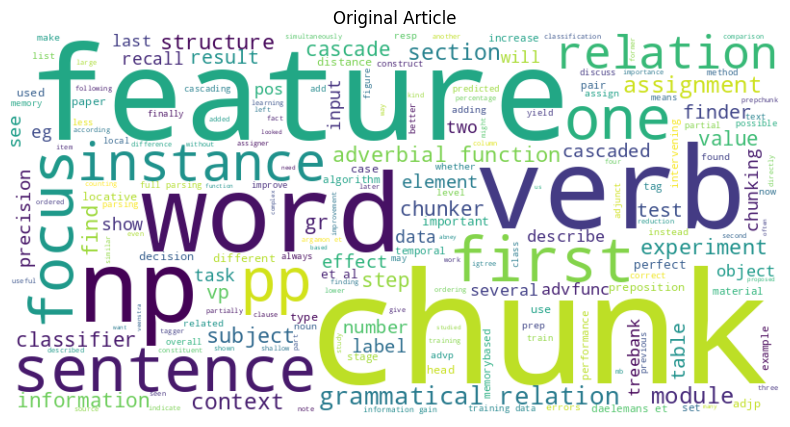

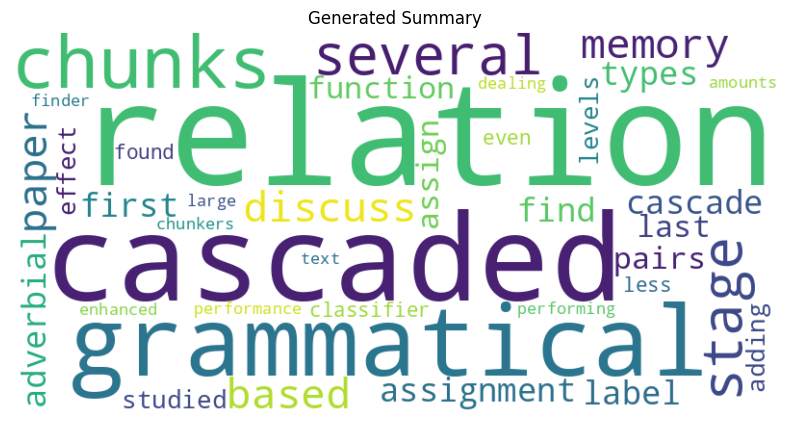

In [20]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

generate_wordcloud(article, "Original Article")
generate_wordcloud(summary, "Generated Summary")